In [1]:
'''
Don't objectify, Quantify
Citations:
    DATA
        HCIILAB. “HCIILAB/SCUT-FBP5500-Database-Release.” GitHub, 16 July 2019, 
        github.com/HCIILAB/SCUT-FBP5500-Database-Release. Accessed 2 June 2021.

    ARCHITECTURE
        Dima Shulga. “How Attractive Are You in the Eyes of Deep Neural Network?” Medium, 
        Towards Data Science, 12 Apr. 2018, 
        towardsdatascience.com/how-attractive-are-you-in-the-eyes-of-deep-neural-network-3d71c0755ccc,             Accessed 2 June 2021.
    
    OUTPUT PROCESSING
        shudima. “Shudima/Notebooks.” GitHub, 2021, 
        github.com/shudima/notebooks/blob/master/Beauty%20Classifier.ipynb. 
        Accessed 3 June 2021.
    
Constraints:
    Square Photo, Light Background, Majority of Image must be your face
'''


import tensorflow as tf
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import os
import torchvision.transforms as transforms
import random
import scipy
from PIL import Image
from tensorflow import keras
from tensorflow.keras import applications
from tensorflow.keras.preprocessing import image
from tensorflow.keras.applications import ResNet50
from sklearn.preprocessing import MinMaxScaler
from scipy import stats


In [2]:
def preprocessing(fileName):
  trainDir = "/Users/NiravShah/Downloads/SCUT-FBP5500_v2/train_test_files/split_of_60%training and 40%testing/" + fileName

  imageDir = "/Users/NiravShah/Downloads/SCUT-FBP5500_v2/Images/"

  images = []
  scores = []

  with open(trainDir, 'r') as f:
    lines = f.readlines()
  for l in lines:
    ls = l.split('\n')[0].split(' ')
    images.append(image.img_to_array(image.load_img(imageDir + ls[0])))
    scores.append(float(ls[1]))

  data = list(zip(images, scores))
  random.shuffle(data)
  images, scores = zip(*data)
  images = np.array(list(images))
  scores = np.array(list(scores))
  scaler = MinMaxScaler().fit(scores.reshape(-1, 1))
  scores = scaler.transform(scores.reshape(-1, 1))
  return images, scores, scaler

def prep_image(filepath):
  picture = image.img_to_array(image.load_img(filepath))
  return picture


In [3]:
testImages, testScores, scaler = preprocessing("test.txt")
trainImages, trainScores, scaler = preprocessing("train.txt")

In [26]:
resnet = ResNet50(include_top=False, pooling='avg')
model = keras.Sequential()
model.add(resnet)
model.add(keras.layers.Dense(1))
model.layers[0].trainable = False
print(model.summary())
model.compile(loss='mean_squared_error', optimizer="adam", metrics=[tf.keras.metrics.Accuracy()])
'''
checkpoint_path = "training_1/cp.ckpt"
checkpoint_dir = os.path.dirname(checkpoint_path)
cp_callback = tf.keras.callbacks.ModelCheckpoint(filepath=checkpoint_path,
                                                 save_weights_only=True,
                                                 verbose=1)
'''
model.fit(batch_size=32, x=trainImages, y=trainScores, epochs=15)
model.layers[0].trainable = True
model.fit(batch_size=32, x=trainImages, y=trainScores, epochs=15)

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
resnet50 (Functional)        (None, 2048)              23587712  
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 2049      
Total params: 23,589,761
Trainable params: 2,049
Non-trainable params: 23,587,712
_________________________________________________________________
None


TypeError: 'property' object is not iterable

In [ ]:
!mkdir -p saved_model
model.save('saved_model/my_model2')
model.save_weights

In [ ]:
new_model = tf.keras.models.load_model('saved_model/my_model2')
new_model.summary()
loss, acc = new_model.evaluate(testImages, testScores)
print("Restored model, accuracy: {:5.2f}%".format(100 * acc))

In [4]:
import tensorflow as tf
import matplotlib.pyplot as plt
from PIL import Image
from tensorflow import keras
from tensorflow.keras.preprocessing import image
from sklearn.preprocessing import MinMaxScaler
from scipy import stats
new_model = tf.keras.models.load_model('saved_model/my_model')
trainImages, trainScores, scaler = preprocessing("train.txt")

Your Scaled Score: 7
Your Raw Score: 1
Your Percentile: 75.5


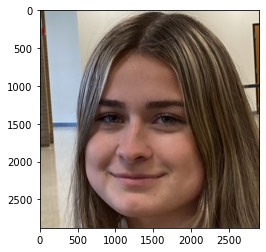

In [5]:
prep_image = lambda filepath: image.img_to_array(image.load_img(filepath))

picture = prep_image("/Users/NiravShah/Downloads/anna.jpg")
#picture = prep_image("/Users/NiravShah/Downloads/SCUT-FBP5500_v2 2/Images/AF1590.jpg")

plt.imshow(picture/255.0)
rawScore = new_model.predict(picture.reshape((1,) + picture.shape))
scaledScore = scaler.inverse_transform(rawScore.reshape(-1, 1))
print(f'Your Scaled Score: {int(scaledScore[0][0] * 2)}')
print(f'Your Raw Score: {int(rawScore[0][0] * 2)}')
print(f'Your Percentile: {round(stats.percentileofscore(testScores, rawScore[0][0]), 2)}')